Last edited: June 13, 2016
# Working with APF Data
By Haynes Stephens

### About this tutorial

This tutorial introduces you to APF fits format data. It is intended for beginners with little to no Python experience. You'll need to have [Jupyter](http://www.jupyter.org) installed, along with a scientific Python installation (numpy, scipy, matplotlib [specifically [pyplot](http://matplotlib.org/users/pyplot_tutorial.html)], [astropy](http://www.astropy.org), and [lmfit](https://lmfit.github.io/lmfit-py/index.html)).
This focus of this tutorial is to help you understand how to:
- work with a `.fits` file
- plot the full spectrum
- indentify and plot the H-alpha absorption feature from the full spectrum
- create a reduced spectrum
- indentify and plot the H-alpha absorption feature from the reduced spectrum
- perform a gaussian fit on the reduced H-alpha absorption feature
- create an algorithm to identify cosmic rays

### About the data

For the purposes of this tutorial, we suggest that you download `ucb-amp194.fits` from this Breakthrough Listen [webpage](https://seti.berkeley.edu/listen/data.html). Click on "DOWNLOAD APF SAMPLE DATA" and the '.fits' file should automatically download to your computer. Put the .fits file in the same directory that this Jupyter notebook is stored in. That way it can be opened as you run the commands in this tutorial.
### Let's get started!

## Working with a `.fits` file 
First, we're going to want to import the pyfits, matplotlib, and numpy libraries. The pyfits library allows us to open and explore the data in '.fits' file. The matplotlib library is used for plotting data, including spectra. The numpy library helps with modifying arrays, which is how the data in our '.fits' file will be organized.

In [21]:
%matplotlib inline

In [15]:
import numpy as np
import pyfits as pf
import matplotlib
from matplotlib import pyplot as plt
import lmfit
from lmfit import minimize, Parameters, report_fit, fit_report
from IPython.display import Image

Now that we have imported the necessary libraries, let's open the APF data file.

In [22]:
apf_file = pf.open('ucb-amp194.fits copy')

This file is full more information than just the data that we want to use. For example, it also contains a header which holds information about the astronomical object observed, and details about the instrument and telescope that was used. Important information such as the date of observation is also included. We can use a command to extract that header and print its information.
  

In [18]:
header = apf_file[0].header
print(repr(header))

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 2080 / NUMBER OF COLUMNS                              
NAXIS2  =                 4608 / NUMBER OF ROWS                                 
CRVAL1U =                    0 / COLUMN ORIGIN                                  
CRVAL2U =                    0 / ROW ORIGIN                                     
CDELT1U =                    1 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                    1 / ROW CHANGE PER PIXEL                           
OBSNUM  =                  194 / OBSERVATION NUMBER                             
IDNUM   =                    3 / IMAGE ID                                       
UGEOM   =                    1 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

Fits files can hold a lot of information. We use the index '0' in the `apf_file` to access the spectral information.

There are many lines in the header that we will not need for this tutorial, but there are some cool details that we can find. By indexing the header we can see details about this data. We can see the Right Ascension (`RA`) and Declination (`DEC`) of the APF telescope at the time of this observation, as well as the name of the target object (`TOBJECT`) being observed.


In [19]:
print("Right Ascension: " + header['RA'])
print("Declination: " + header['DEC'])
print("Target Object: " + header['TOBJECT'])

Right Ascension: 20:06:15.5
Declination:  44:27:24.6
Target Object: KIC8462852


This star is named KIC8462852, also known as Tabby's star. The 'KIC' designation comes from names used for stars observed by NASA's Kepler Space Telescope.

### Now let's explore the data
Let's pull out the data we want to use. 

In [20]:
image = apf_file[0].data

We've titled this data the `image` because it's the spectrum that was taken by the APF, and we will be displaying it visually. Again, index at '0'.

This data is in the form of a numpy array. If you have no previous exposure to numpy arrays, you might want to skim over this quick [tutorial](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html). It's basically a two-dimensional matrix. Each index of the array is a pixel number, and the value at that given index the flux measured on that pixel. A quick example, let's create a 2x2 array and call it "cookies".

In [25]:
cookies = np.array([[1,2,3],[4,5,6]])
print(cookies)

[[1 2 3]
 [4 5 6]]


If we want the top left value of `cookies` we have to index it at `[0,0]` because Python uses zero-based indexing. We pull the value at that index by typing `cookies[0,0]`. 


In [26]:
print(cookies[0,0])

1


Our data works essentially the same way. If we treat `cookies` as an array of data, then we can say that the pixel `[0,0]` has a flux value of `1`. Hopefully this helps youd understand a little bit about numpy arrays. 
## Plotting the full spectrum
Now let's try plotting it to see what we get. We'll use the `plt.imshow()` function to plot the data as an image and alter its display.

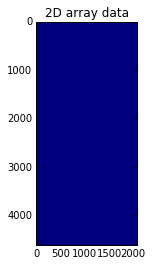

In [27]:
plt.imshow(image)
plt.title('2D array data')

Woah, that's not what we want. Our array is displayed, but everywhere on it looks the same. We need more contrast in our image so that we can tell the different pixels apart. 

We can use `vmin` and `vmax` within our `plt.imshow()` function to set the range of values that will be shown. 
Any values lower than the lower boundary of our range will look the same, as well as any values greater than our upper limit.

We also want the origin of our plot `(0,0)` to be on the bottom left instead of the upper left. We can set that by including `origin = 'lower'` in our plotting function. 

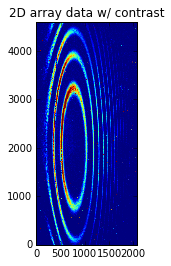

In [12]:
plt.imshow(image, vmin = np.median(image), vmax = np.median(image) * 1.2, origin = 'lower')
plt.title('2D array data w/ contrast')

We have used the `np.median()` function to get the median value of our data, and set the range according to that value. We used the factor of 1.2 to set the upper limit to our range for contrast, but it could be any number you want.

This is better, but this image is still not the same as what we see in the [webpage](https://seti.berkeley.edu/listen/data.html):
![Image of Full Spectrum](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/web_pic_APF194%20copy.png?token=AR2HYAv61faytP4wety4GUdScAkjTFSjks5XaBV-wA%3D%3D)

To fix that, we need to do a couple of tricks with our array.

First, let's rotate the array 90 degrees in the counter-clockwise direction. We can do this using the `np.rot90()` function on our numpy array. Then we replot the data. Let's set the figure size manually too, using the `plt.figure()` function with the parameter `figsize=()`, so that we can see our plot large enough to examine it closely. 

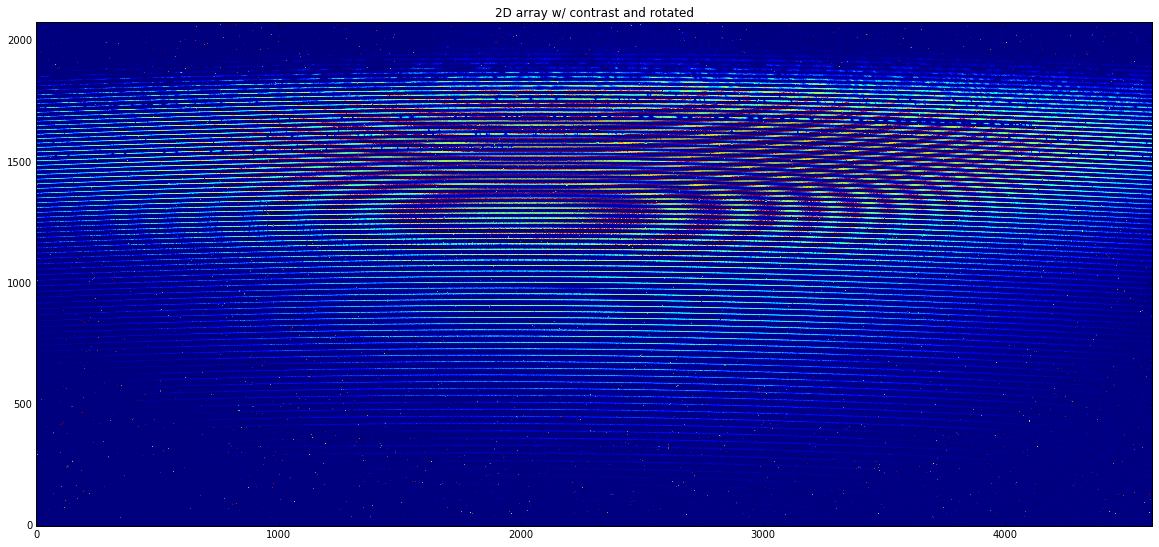

In [28]:
image_rot = np.rot90(image)
plt.figure(figsize=(20,20))
plt.imshow(image_rot, vmin = np.median(image_rot), vmax = np.median(image_rot) * 1.2, origin = 'lower')
plt.title('2D array w/ contrast and rotated')

Even better! The details are beginning to emerge on the spectrum. Now we need need to flip the image horizontally to match the image on the website. Numpy has an exact function for this, the `'np.fliplr()` function ('lr' meaning 'left and right'). Let's use that and see what we have done.

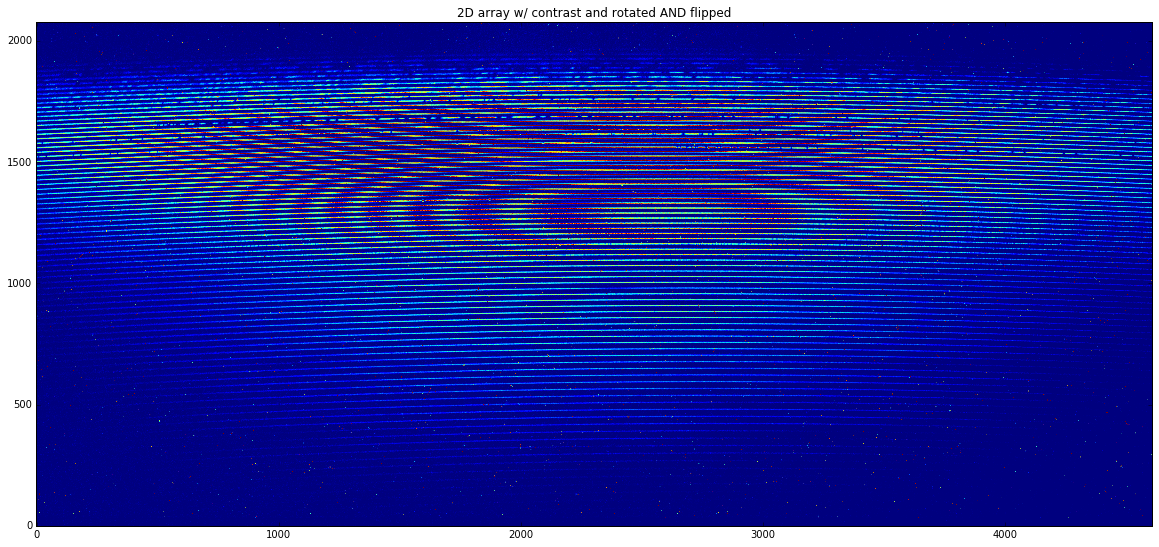

In [29]:
image_flip = np.fliplr(image_rot)
plt.figure(figsize=(20,20))
plt.imshow(image_flip, vmin = np.median(image_flip), vmax = np.median(image_flip) * 1.2, origin = 'lower')
plt.title('2D array w/ contrast and rotated AND flipped')

Got it! Now let's change the coloring of our image, using `cmap` within our `plt.imshow()` function. If we set `cmap = 'gray'` then we can get a grayscale from black to white, which will simplify the display. Now our image will match that on the Breakthrough Listen website.

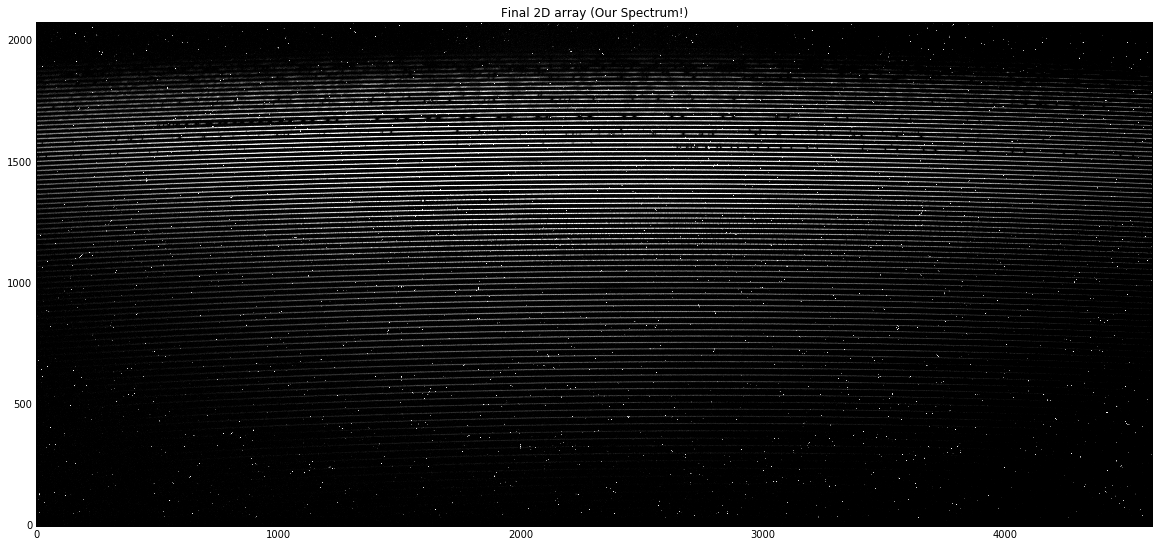

In [30]:
plt.figure(figsize=(20,20))
plt.imshow(image_flip, cmap = 'gray', 
           vmin = np.median(image_flip), vmax = np.median(image_flip) * 1.2, origin = 'lower')
plt.title('Final 2D array (Our Spectrum!)')

#### There it is! :-)

## Indentifying and plotting the H-alpha absorption feature from the full spectrum

Now that we have our 2D array displayed, we can look for absorption lines in our spectrum. The best way to do this is to zoom in on the image and look for distinct dark spaces along the curved white lines. 

Let's start by looking for some telluric absorption lines. These are spectral featuers caused by the oxygen in Earth's atmosphere. These lines are imprinted on stellar spectrum as the starlight passes through the Earth's atmosphere. A little hunting through the image and we notice some distinct dark spots within a patch in the upper portion of the image. 

![Image of cutout APF 1](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_spec_APF1%20copy.png?token=AR2HYLk76zZTDjvx9NlF-BKKqGIWU71tks5XaBXPwA%3D%3D)

The patch spans 5 rows vertically (rows 1683 to 1687) and 600 columns across (columns 2200 to 2799). We can show a 2D array of this patch by using the `plt.imshow()` function with `image[1683:1688, 2200:2800]`, instead of using `image`. Let's create a new array which is that small patch of the original image. 

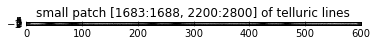

In [14]:
patch = image_flip[1683:1688, 2200:2800]
# ^ Cutout of our 2D array, like a patch out of a quilt
plt.imshow(patch, cmap = 'gray', 
           vmin = np.median(image_flip), vmax = np.median(image_flip) *1.2, origin = 'lower')
plt.title('small patch [1683:1688, 2200:2800] of telluric lines')


Woah! It's so tiny! This is because our array is 5x600. If we try to plot it normally then matplotlib is going to make our x-axis 120 times (600 divided by 5) longer than our y-axis, giving us an image with nothing to see. 

But we can change this! If we add the parameter `aspect = 'auto'` into our `plt.imshow()` function then we our axes will become more similar in size. This will be able to see details in our plot. 

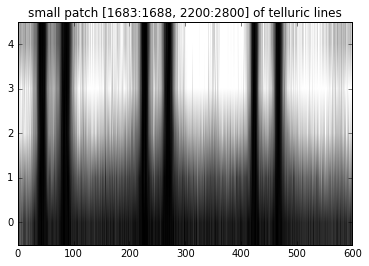

In [31]:
plt.imshow(image_flip[1683:1688, 2200:2800], cmap = 'gray', aspect = 'auto', 
           vmin = np.median(image_flip), vmax = np.median(image_flip) *1.2, origin = 'lower')
plt.title('small patch [1683:1688, 2200:2800] of telluric lines')

Notice the expansion of the y-axis.

Can you see how this image was cut out from the original spectrum?

![Image of cutout APF 2](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_spec_APF2%20copy.png?token=AR2HYAcTLDlM3a00Hfr2YkFc12hpXcLnks5XaBYAwA%3D%3D)

In the image above, those dark spots between white spikes are our absorption lines. This patch is 5 pixels tall (1683 to 1687, including 1683) and 600 pixels wide (2200 to 2799, including 2200).

In [16]:
patch = image_flip[1683:1688, 2200:2800]
patch.size

3000

`patch` is an arry with dimensions 5x600. 

### Plotting the line

Using this `patch`, we want to plot a 1D array so that we can see a graph of flux vs. pixel. We can do this by summing up all of the columns of `patch` so that we can obtain an array that is 1x600. To do this, we use the `np.sum()` function and set our `axis` equal to '0' (so that it sums columns and not rows).

In [17]:
telluric_1D = np.sum(patch, axis = 0)

Now that this array is one-dimensional, we can get a simpler plot by using the `plt.plot()` function.

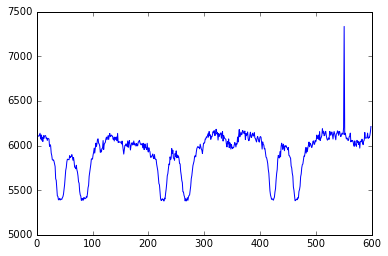

In [18]:
plt.plot(telluric_1D)

This looks almost like what we want. Those deep dips that you see are the absorption lines. That tall spike on the far right of the plot is due to a cosmic ray. We will talk about cosmic rays later, but for now let's focus on the absorption features, the dips. 

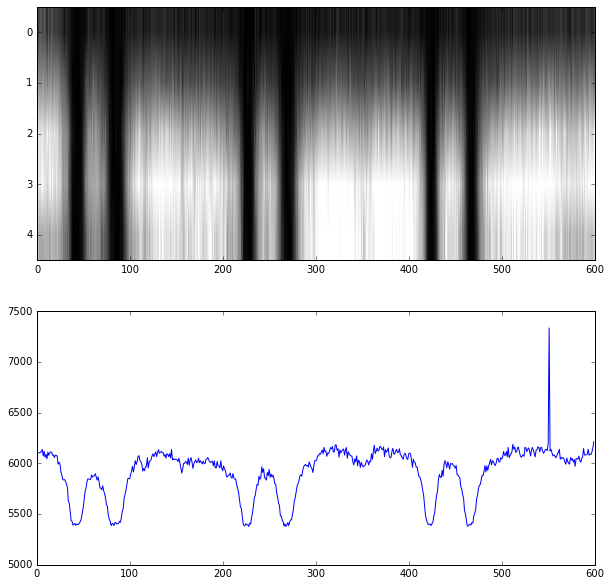

In [19]:
plt.figure(figsize =(10,10))
plt.subplot(2,1,1)
plt.imshow(image_flip[1683:1688,2200:2800], cmap = 'gray', aspect = 'auto', 
           vmin = np.median(image_flip), vmax = np.median(image_flip) *1.2)
plt.subplot(2,1,2)
plt.plot(telluric_1D)

Look at the two graphs above and you can see the correlation between the dark spots in the top image, and the absorption dips in the bottom image. 

![Image of cutout lines](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_lines%20copy.png?token=AR2HYFe9pYut9A7wFEB1ITGguWBvlGZ1ks5XaBYkwA%3D%3D)

##### This is good!


### Correcting for bias

The only major problem of this graph is that it has a baseline of almost 5500 flux units, but we want the baseline of our graph to have a value 0 flux units. This is due to the flux bias of the APF, and we have to correct for this bias. 

A standard practice used to determine the bias is to find the most common pixel value in the rows at the very bottom of our spectrum, and make that the correction value. The rows used to measure the bias do not have any starlight on them. They are called 'overscan' rows. We then subtract the bias value from every pixel in the image in order to correct for the bias. 

For this tutorial, we will take the median pixel value of the bottom 30 rows of our original 2D array and use that as our bias value.  

In [20]:
bias = np.median(image_flip[-30:])
print(bias)

1073.0


Now we can adjust our one-dimensional telluric plot. To do that we need to subract the bias from each order of our array. Since our array is the sum of five orders (`[390:395]`), we need to subtract the bias five times in order to get a baseline at '0'. Let's call this new array `telluric_1D_adj` because it has been adjusted to correct for the bias.

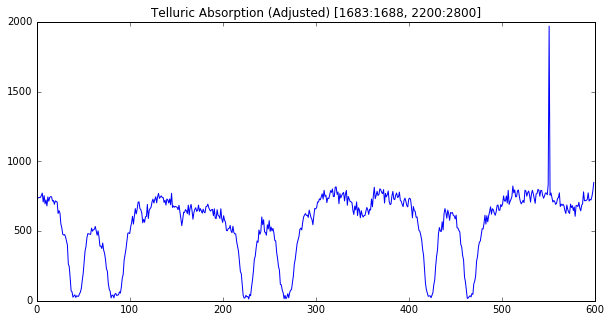

In [21]:
plt.figure(figsize=(10,5))
telluric_1D_adj = telluric_1D - (5*bias)
plt.plot(telluric_1D_adj)
plt.title('Telluric Absorption (Adjusted) [1683:1688, 2200:2800]')

Now we see that the absorption features have intensity measurements in the middle of the aborptionlines of nearly zero flux. Spectral lines from the star can have nearly any depth, the telluric lines are special in that they reach nearly zero. Any measurements along the y-axis that are below zero are simply a result of the noise in the data gathered.

### Any patch you want

Now that we've gone through it once, you can try plotting absorption lines for any patch of the spectrum that you want. Let's create a function in Python that will automatically create a patch using any valid coordinates as input, and give it a standard figure size of 10x10. 
We'll call it `cut_n_zoom()`


In [22]:
def cut_n_zoom(x1,x2,y1,y2):
    plt.figure(figsize=(10,10))
    plt.imshow(image_flip[x1:x2, y1:y2], cmap = 'gray', aspect = 'auto', 
               vmin = np.median(image), vmax = np.median(image) *1.2, origin = 'lower')
    plt.show()

### Finding H-alpha

Now that we have seen some spectral features and plotted a one-dimensional spectrum of the features, let's go find the H-Alpha line. The H-alpha line for this particular `.fits` file is not very distinct, but is still noticable if we can find the right patch. 
For an APF data file, the H-alpha line is very often located close to the pixel at index `[1509:2049]` on the array. Through some trial and error I found that the best patch to cover on `image_flip` is `[1491:1506,1500:2500]`. Let's select this patch, take the sums along each column, and subtract the bias to see if we can notice any features. Since we are adding together fifteen pixel values per column we need to subtract fifteen biases from the final array.

In [23]:
#cutting out the patch with the absorption feature
h_alpha_patch = image_flip[1491:1506,1500:2500] 
#take the sum along the columns, and subtract 15 biases
h_alpha_patch_1D_without_bias = np.sum(h_alpha_patch, axis = 0) - bias*15 

Now let's plot the array we have created

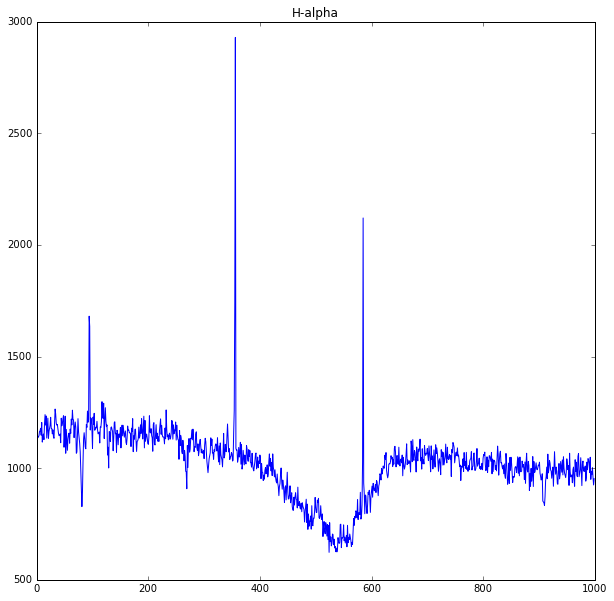

In [24]:
# Plotting H-alpha absorption line
plt.figure(figsize=(10,10))
plt.plot(np.sum(h_alpha_patch, axis = 0) - bias*15)
plt.title('H-alpha')

There it is! That dip between `x=400` and `x=600` is an absorption feature due to the [Balmer-Alpha](https://en.wikipedia.org/wiki/H-alpha) transition caused by the absorption of photons (light) by Hydrogen, hence the name H-alpha. 

### extra: sodium-D lines

Next, look for some other absorption features and plot them. Let's go for the [Sodium-D (Na-D) absorption lines](https://en.wikipedia.org/wiki/Fraunhofer_lines). 
The patch for the Na-D lines stretches roughly from `[1333:1348, 1200:2200]`. We can use the exact same process as we did for the Telluric lines, and make a plot of the one-dimensional data which will show the Na-D lines.

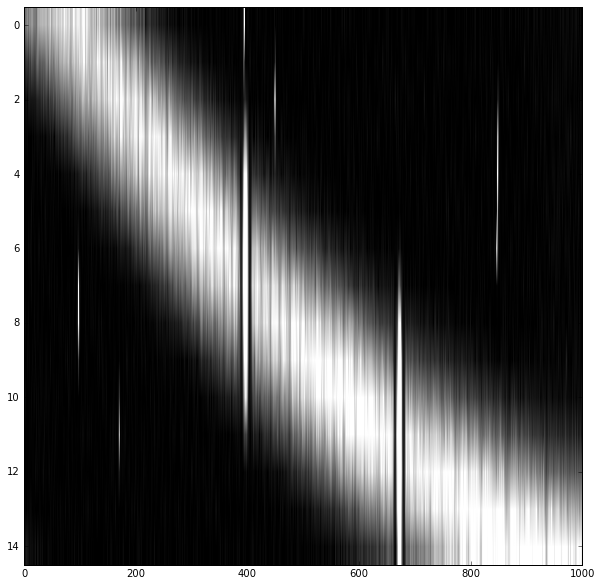

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(image_flip[1333:1348,1200:2200], cmap = 'gray', aspect = 'auto', 
           vmin = np.median(image_flip), vmax = np.median(image_flip) *1.2)

Do you see those two vertical bright lines? 
See how each of those vertical bright lines is between two dark lines? The four red arrows below point to the four dark lines. 
![Image of cutout Na-D lines](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_NaD_lines%20copy.png?token=AR2HYF8sq727BwzvfHeItQO7KbupEFCBks5XaBa-wA%3D%3D)
![Image of cutout Na-D liens](cutout_NaD_lines_1D copy.png)
Those dark lines are the Sodium-D absorption lines. 

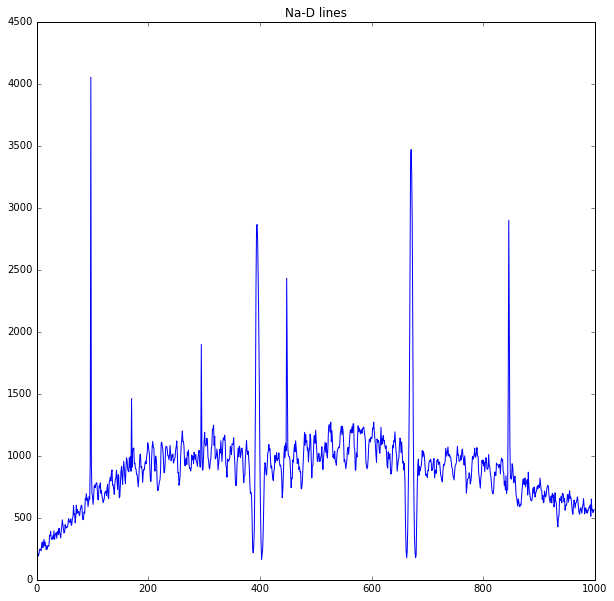

In [26]:
Na_D_patch = image_flip[1333:1348, 1200:2200]
Na_D_patch_1D = np.sum(Na_D_patch, axis = 0) - bias*15
plt.figure(figsize=(10,10))
plt.plot(Na_D_patch_1D)
plt.title('Na-D lines')

There are two pairs of absorption features in this plot, shown below by the red arrows. These are the Sodium-D absorption lines.
#### Streetlight emission
Notice the tall spikes in between each pair of Sodium-D absorption features, shown within the red boxes. These spikes in intensity are caused by the street lights from San Jose which is about 30 miles from the APF telescope at Lick Observatory. Typical streetlights use bulbs with low-pressure or high-pressure sodium in an excited state to emit an orange colored light. The emission from these streetlights can often be detected by telescopes, resulting in these tall spikes among the Sodium-D absorption features. The other spikes on this plot are likely from cosmic rays.
![Image of cutout Na_D_1D](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_NaD_lines_1D%20copy.png?token=AR2HYM-bktsMdai6gYzYLMmLgwZTy3qtks5XaBbrwA%3D%3D)

If we look at the two-dimensional image again, shown below, and compare it with the one-dimensional image, we can see the similarities. The bright spots within the boxes are the streetlight emission, and the dark lines are the Sodium-D absorption lines.
![Image of cutout Na-D lines](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_NaD_lines%20copy.png?token=AR2HYF8sq727BwzvfHeItQO7KbupEFCBks5XaBa-wA%3D%3D)



## Creating a reduced spectrum
Let's take another look at the full spectrum we created earlier in the tutorial.
![Image of Full spectrum](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/web_pic_APF194%20copy.png?token=AR2HYPpQ3tXR58drGrp5c5c-demq3DOnks5XaBcIwA%3D%3D)

Do you notice how there are dark spaces between the horizontal white lines? They become bigger toward the bottom of the image. These are not absorption features. Absorption features are recognized as dark breaks within the same white line, but not between different lines. So if they are not absorption features, then what are these dark spaces? They are just spaces between the orders recorded on the CCD, and they are shown in the `.fits` file's raw data. 

Also, can you see how the white lines in the full spectrum curve ever so slightly? It is very hard to notice looking at the entire image, but let me see if I can help make it clearer. Let's look at this full spectrum below, with a box put around the line that shows the telluric absorption features.
![Image of Curve Show](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_curve_show%20copy.png?token=AR2HYKcHmRZdjWVM0LCgar9ro_-z8oc1ks5XaBcbwA%3D%3D)

Do you notice the line that showing many dark breaks that starts out at the bottom-left of the box? If you follow that same line to the right, can you see how it almost reaches the top of the box around the center of the image?

All of these white lines are actually curved. If I cutout a small patch from the raw data and plot it then the curves look more severe. I can choose any lines to show this, so I'll randomly choose the patch `[1650:1750]`, which is 100 orders vertically and stretches all the way across the array. 


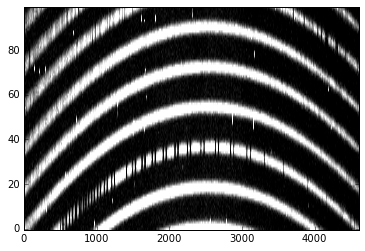

In [27]:
plt.imshow(image_flip[1650:1750], aspect = 'auto', origin = 'lower', cmap = "gray", 
           vmin = np.median(image_flip), vmax = np.median(image_flip) *1.1)

The curves are a result of the curved optics used in the telescope being displayed on a flat CCD. 

We want to create an image that doesn't have dark spaces between the white lines and that has the lines that are straight instead of curved. We want to create something called a reduced spectrum. The reduced spectrum is rid of the distortions that come from the circular optics used in the telescope, and merges all of the pixel orders together. 

A reduced spectrum has already been created from the `ucb-amp194.fits` file that we have been working with during this tutorial. The `.fits` file that contains the reduced spectrum is named `ramp.194.fits`. Notice the difference in the dimensions between the raw data array and the reduced data array.

Whereas the raw data array has dimensions 2080 pixels by 4608 pixels,
this reduced data array has dimensions 79 pixels by 4608 pixels.


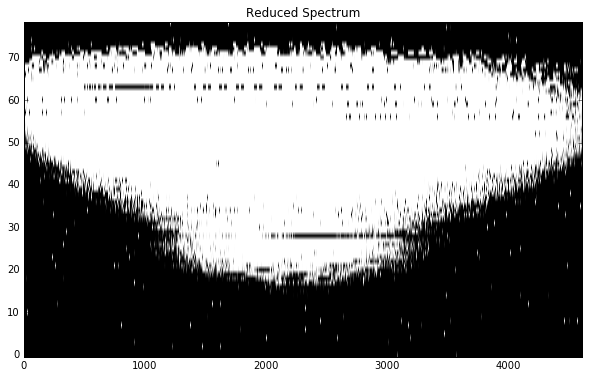

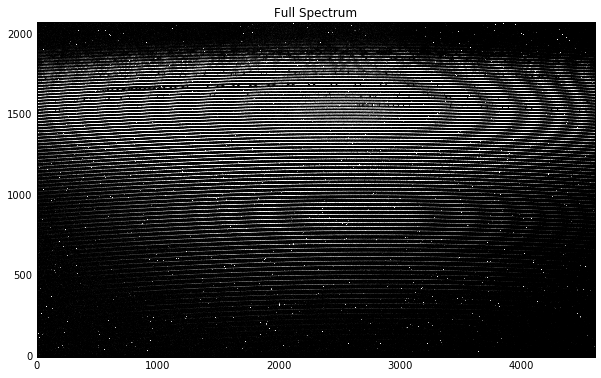

In [28]:
#Load the reduced .fits file and extracting the data
apf_reduced = pf.open('ramp.194.fits copy')
reduced_image_fits = apf_reduced[0].data
#Plot an image of the reduced data
plt.figure(figsize=(10,6))
plt.imshow(reduced_image_fits, cmap = "gray", origin = "lower", aspect = "auto", 
           vmin = np.median(reduced_image_fits), vmax = np.median(reduced_image_fits) *1.1)
plt.title("Reduced Spectrum")
#Plot an image of the raw data
plt.figure(figsize=(10,6))
plt.imshow(image_flip, cmap = "gray", origin = "lower", aspect = "auto", 
           vmin = np.median(image_flip), vmax = np.median(image_flip) *1.1)
plt.title("Full Spectrum")
print("Whereas the raw data array has dimensions %s pixels by %s pixels," % image_flip.shape)
print("this reduced data array has dimensions %s pixels by %s pixels." % reduced_image_fits.shape)

See how the two images have the same length along the the x-axis, but the reduced image has a much smaller range along the y-axis.

If we load the header of this reduced `.fits` file and print some of its information, we can see that it is consistent with the information in `ucb-amp194.fits`. 

In [29]:
print("Right Ascension: " + header['RA'])
print("Declination: " + header['DEC'])
print("Target Object: " + header['TOBJECT'])
header_reduced = apf_reduced[0].header
print("Reduced - Right Ascension: " + header_reduced['RA'])
print("Reduced - Declination: " + header_reduced['DEC'])
print("Reduced - Target Object: " + header_reduced['TOBJECT'])

Right Ascension: 20:06:15.5
Declination:  44:27:24.6
Target Object: KIC8462852
Reduced - Right Ascension: 20:06:15.5
Reduced - Declination:  44:27:24.6
Reduced - Target Object: KIC8462852


But what if we encouncter an APF data file that does not already have a reduced spectrum? In that case, it is good to know how to create a new reduced spectrum using the raw data. This may seem difficult if you are fairly new to Python, but I will try my best to explain each step clearly. First, we have to return to the topic of the curves in the raw data.

Each of the curved white lines follows a specific fourth-order polynomial function. Luckily, for this tutorial we do not have to find all of these polynomials. We have been given a `.txt` file which has the coefficients for the polynomial of each of the lines in the full spectrum. The file is named `order_coefficients.txt`. We can open and read this file using some Python script. Let's split the text in this file by each line using the `splitlines()` function, so that each line of text has the coefficients to each polynomial of the data. We'll print the first line to see what it looks like.

In [30]:
text = open('order_coefficients copy.txt', "r")
lines = text.read().splitlines()
print lines[0]

      103.686    0.0725580 -1.27386e-05 -1.01114e-10  2.53449e-14


This line of text has five different numbers in it. Each number is a coefficient to one fourth-order polynomial function, from x^0 (raised to the power zero) to x^4. These five coefficents are contained within a string because they were read from a text file. 

If we want to extract the numbers we need to splice them out of the string. We can do so by taking the indexes of the string that represent each coefficient, and turn them into a float (number decimal) using the `float()` function. I've also used the `strip()` function, which removes any blank characters, or space marks. I did that because some coefficients have a negative sign in front, and some have a blank space because they are positive. We can extract the coefficients of the first line of text with these functions.

In [31]:
a0 = float(lines[0][6:13].strip())
a1 = float(lines[0][17:26].strip())
a2 = float(lines[0][27:39].strip())
a3 = float(lines[0][40:52].strip())
a4 = float(lines[0][54:].strip())
print(a0, a1, a2, a3, a4)

(103.686, 0.072558, -1.27386e-05, -1.01114e-10, 2.53449e-14)


- a0 = coefficient for x^0 (constant term)
- a1 = coefficient for x^1
- a2 = coefficient for x^2
- a3 = coefficient for x^3
- a4 = coefficient for x^4

We want to store the polynomial coefficients for each of the seventy-nine orders. We could get the coefficients by hand and brute force our way through the process, but let's make it easier on ourselves. Instead, let's create an empty array and fill it in with the coefficients by iterating throught the `lines` of the text file. There are five coefficients for each order, so our array needs dimensions of 79 by 5. We can start by making the array full of zeros, and then later changing those values to the coefficients. Let's call this array `coeff_array`.

In [32]:
coeff_array = np.zeros((79,5))

Now we have an array of zeros that has the right dimension to fit five polynomial coefficients for seventy-nine different polynomial functions.

Next, let's set up the iteration that will go through each line and extract the coefficients. This is the exact same code that we used to get the coefficients above, except now it will work for each of the seventy-nine polynomials in the file. As we iterate through the lines we can create an array for each line of coefficients, named `coeffs_one_line`, and add the values in that array to the `coeff_array`. 

In [33]:
for i in range(len(lines)):
    a0 = float(lines[i][6:13].strip())
    a1 = float(lines[i][17:26].strip())
    a2 = float(lines[i][27:39].strip())
    a3 = float(lines[i][40:52].strip())
    a4 = float(lines[i][54:].strip())
    coeffs_one_line = np.array([a0,a1,a2,a3,a4])
    coeff_array[i] += coeffs_one_line

We now have a `coeff_array` full of coefficients for our polynomials.

### Plot the polys
We want to see what the polynomials look like, and make sure that our coefficients were correct, so let's plot them over the raw image. 

First, we must plot the image data. Second, we need to plot each of our polynomial functions. In order to do that we need to take the coefficients from each order and plot them versus the values of x from 0 to 4607 (same dimension as the width of the raw image). Let's create an array of x values from 0 to 4607 by using `np.arange()`. Then we can iterate through our array of polynomial coefficients, `coeff_array`. As we iterate, we create a unique fourth-degree polynomial function with the coefficients from each order of `coeff_array`. We can plot that function with increasing x values in the `x` array, and show that over our raw image. Look for the colorful lines.

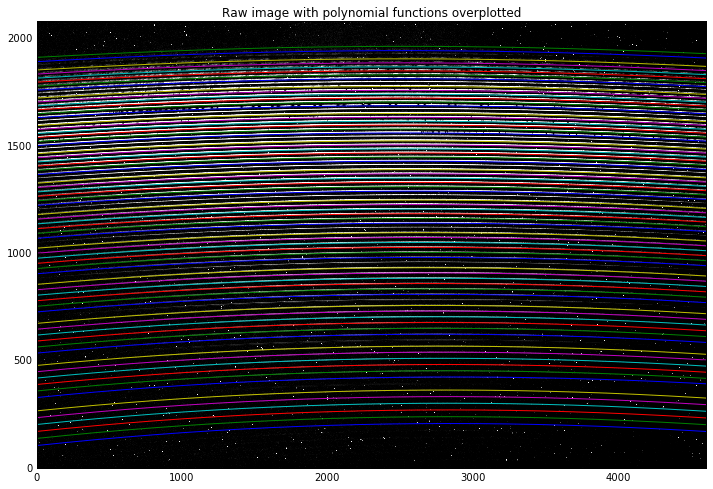

In [34]:
#Plots raw image
plt.figure(figsize=(12,8))
plt.imshow(image_flip, cmap = "gray", origin = "lower", 
        aspect = "auto", vmin = np.median(image_flip), 
        vmax = np.median(image_flip) *1.1)
#Sets array of x values, which the polynomials can then be plotted with
x = np.arange(0,4608)
#Plots each polynomial function over the raw image
for i in range(coeff_array[:,0].size):
    a0 = coeff_array[i,0]
    a1 = coeff_array[i,1]
    a2 = coeff_array[i,2]
    a3 = coeff_array[i,3]
    a4 = coeff_array[i,4]
    #Plots each order of coefficients to fit a fourth-degree polynomial
    plt.plot(x, a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4)
    #Sets the limit on the x-axis and the y-axis shown in the plots
    plt.xlim(0,4608)
    plt.ylim(0,2080)
plt.title("Raw image with polynomial functions overplotted")


Perfect! See how well the functions line up with the orders. Here, let me zoom in a little to give you a better look.

![Image of Poly Functions](https://raw.githubusercontent.com/stevecroft/bl-interns/master/hstephens/cutout_poly_functions_show%20copy.png?token=AR2HYKBAmUXtnewTt_zoP8x3cDJY2x_Mks5XaBdFwA%3D%3D)

So far really great. Now something a little more tricky. In order to successfully create a reduced image, we need only worry about the pixels that are along these polynomial functions. We need to find out which pixels those are first. Can you think of any ways we could do this? Looking at the latest plot that we made might give some clues.

Let's think about one polynomial to get started. If we can find all of the x values and y values along that polynomial then we can find all of the pixels along that order in the raw image that we want to keep for the reduced image. For example, if one polynomial has a point (x1, y1) where x = x1 and y = y1. The pixel in `image_flip` that is at that same point on the plot is `image_flip[y1,x1]`. The switch in coordinates happens because arrays are indexed by row (vertically) first and then by column (horizontally). 

If we get the x values and y values for all of the polynomial functions, then we will have all of the pixel values that we want to use to create our reduced spectrum. Just to be safe, let's take three pixels above and three pixels below our `image_flip[y1,x1]`, and then sum them up into one pixel. This way we make sure we're not missing any important pixels. Now we just have to remember that since we'll be summing up a total of seven pixels each time we will need to subtract seven bias values to adjust properly.

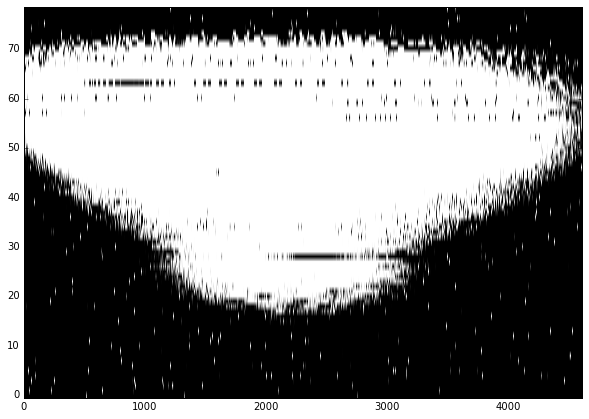

In [35]:
#Array of increasing x values
x = np.arange(0, 4608)
#Empty array to fill in with y values from polynomials
y_values = np.zeros((79,4608))
#Empty array to fill in to create our reduced spectrum
poly_reduced_image = np.zeros((79,4608))
#Iteration loop that adds y values to the y_values array and 
#adds pixel values to the reduced_image array
for i in range(coeff_array[:,0].size):
    a0 = coeff_array[i,0]
    a1 = coeff_array[i,1]
    a2 = coeff_array[i,2]
    a3 = coeff_array[i,3]
    a4 = coeff_array[i,4]
    for j in range(x.size):
        y = a0 + a1*x[j] + a2*x[j]**2 + a3*x[j]**3 + a4*x[j]**4
        y_values[i,j] = y
        y = int(round(y))
        #We sum the pixel with three pixels above and three pixels below to ensure that 
        #we're including all of the important pixels in our reduced image
        poly_reduced_image[i,j] = int(np.sum(image_flip[y-3:y+4,j], 
            axis = 0)-7*bias)
plt.figure(figsize=(10,7))
plt.imshow(poly_reduced_image, cmap = "gray", origin = "lower", 
    aspect = "auto", vmin = np.median(poly_reduced_image), 
    vmax = np.median(poly_reduced_image) *1.1)

That looks really good! Let's compare it to the reduced image from `ramp.194.fits` to see how they compare. To do this we can make two suplots, one with each image, within the same figure. We can use the `plt.subplot()` function to do this easily. For example, `pltsubplot(2, 1, 1)` will create a figure that is 2 plots long vertically, and 1 plot log horizontally, because the first two numbers are 2 and 1. The third number input in the subplot function indicates which subplot you are working with. So when I plot the `reduced_image` array, it will be in the first position of the two subplots (at the top) because the third number is 1. We'll give these subplots titles to make sure we know which is which. 

Remember that `poly_reduced_image` is the reduced image that we created using the polyfitting technique, and `reduced_image_fits` is the reduced image that we got from the file `ramp.194.fits`.

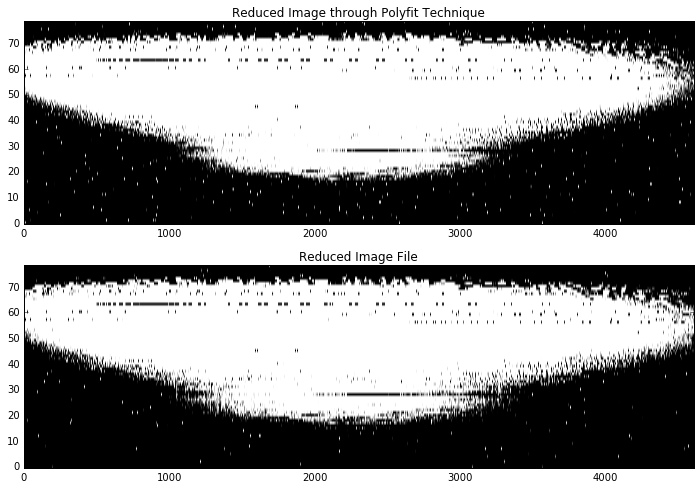

In [36]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.imshow(poly_reduced_image, cmap = "gray", origin = "lower", 
    aspect = "auto", vmin = np.median(poly_reduced_image), 
    vmax = np.median(poly_reduced_image) *1.1)
plt.title("Reduced Image through Polyfit Technique")
plt.subplot(2, 1, 2)
plt.title("Reduced Image File")
plt.imshow(reduced_image_fits, cmap = "gray", origin = "lower", 
    aspect = "auto", vmin = np.median(reduced_image_fits), 
    vmax = np.median(reduced_image_fits) *1.1)

They look almost exactly the same! But remember that the contrast settings on our images using `vmin` and `vmax` are based off of the pixel values relative to the median value of the image. Even though these images may look very similar, it is only because the pixel values of the two images are similar in comparison to their respective median values. It is possible that the pixel values of one image could be much lower than the other image and we still get the same contrast in the two images. So let's choose a random pixel index and see how it compares with the two images. We'll print out the value of the pixel at `[53,2000]` for both reduced images and compare them.

In [37]:
print(poly_reduced_image[53,2000])
print(reduced_image_fits[53,2000])

719.0
698.775


That's pretty close! If you want to make them look even more similar, maybe try summing up a different number of pixels along the polynomials in the raw image. We summed up seven pixels along at each x value of the polynomial functions (the pixel on the function, a pixel above, and a pixel below). Summing up five pixels or nine pixels might get an even better comparison. What we have now is close enough for me to happy and ready to move on. Let's find out what the H-alpha absorption lines look like in these reduced images.

## Identifying and plot the H-alpha absorption feature from the reduced spectrum
The H-alpha line on these reduced images is usually somewhere along the 53rd order of the image. We can look for it by plotting the 53rd order. We'll index at `[53]` instead of `[54]` because we'll call the order `[0]` of the image the zero-ith order, so the indexes match up nicely. Let's see if we can spot the dip of the H-alpha.

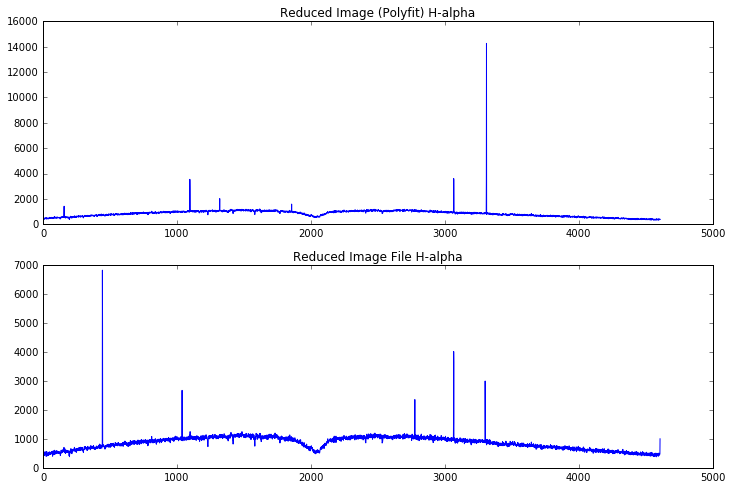

In [38]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(poly_reduced_image[53])
plt.title("Reduced Image (Polyfit) H-alpha")

plt.subplot(2, 1, 2)
plt.plot(reduced_image_fits[53])
plt.title("Reduced Image File H-alpha")

Eureka! Do you see it? It's around the x value of 2000, or the 2000th pixel along the 53rd order.

There are a handful of tall spikes in each image, possibly cosmic rays, which are causing the y axes of our plots to be different from each other. Let's ignore the spikes for now and give the plots the same y axis so that we can see their comparison better. We can set the limits of the y axes using the `plt.ylim()` function. We'll set the lower limit at 0, and the upper limit at 1200.

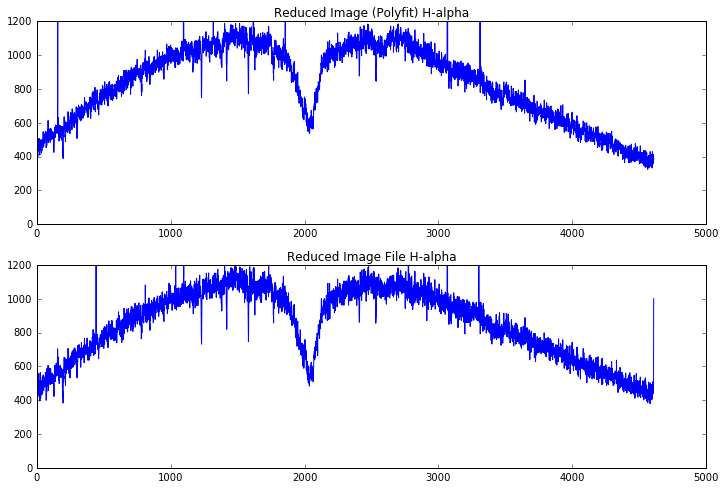

In [39]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(poly_reduced_image[53])
plt.ylim(0,1200)
plt.title("Reduced Image (Polyfit) H-alpha")

plt.subplot(2, 1, 2)
plt.plot(reduced_image_fits[53])
plt.ylim(0,1200)
plt.title("Reduced Image File H-alpha")

Wow, I can hardly tell the difference. The dips look nearly identical, as do the features on either side of the dips. 

#### Now for the real test
The H-alpha absorption features above seem to be fairly wide. We want to get one value for the H-alpha absorption feature right at its center, but where is that exactly? To figure that out we can perform a Gaussian fit onto the plot.

## Performing a Gaussian fit on the reduced H-alpha absorption feature
We can use the Gaussian fit of the data for our absorption feature to determine where the absorption feature is centered. There are many ways to perform a Gaussian fit, but the fasest and easiest way I know is to use the `GaussianModel` from the lmfit library. To import it we need to go into the `lmfit.models` module.

In [40]:
from lmfit.models import GaussianModel

Now we can use GaussianModel to fit our data for us.

But we have one more issue to solve before we fit our data. We don't have much interest in seeing the pixel number where are absorption feature is centered. Since the H-alpha feature is characterized by its wavelength on the electromagnetic spectrum, it would be better to know the wavelength at which our H-alpha feature is centered. In order to do that, we need to set our x axis in the units of wavelength instead of pixel number. 

#### Search for the holy wavelength
We'll have to get another `.fits` file called a wavelength solution, which includes an array of wavelength values. We can plot its values as our x axis. Let's open our wavelength solution named `apf_wave.fits` and pull out the array of wavelength values from the `data`. 

In [41]:
wave = pf.open('apf_wave.fits copy')
wave_values = wave[0].data

We want to plot our intensity values, which show the H-alpha absorption feature, versus the wavelength values. Since we're using the 53rd order of our `poly_reduced_image` array, let's also use the 53rd order of our `wave_values` array as our x axis. We can index both of these orders with `[0:4000]` to get the first 4000 pixels, which is about the same width of the arrays.

In [42]:
x = wave_values[53,0:4000]
y = poly_reduced_image[53,0:4000]

Now let's plot our x and y values to see what it looks like.

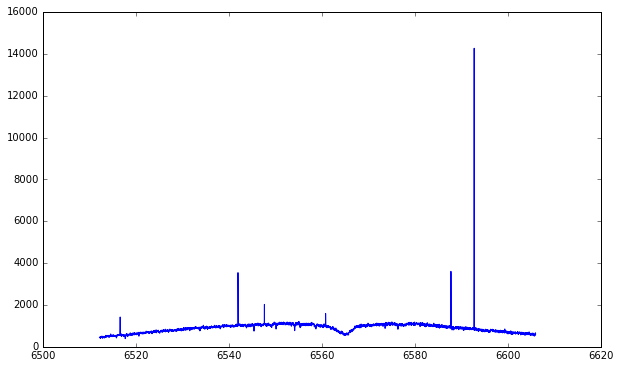

In [43]:
plt.figure(figsize=(10,6))
plt.plot(x,y)

If we look at the x axis of this plot we can see that we now have values from 6500 to 6620. These values are in the units of Angstroms, which are a measurement of wavelength.

#### Gaussian time
We now have the x and y values that we want to peform our Gaussian fit on. Let me briefly describe the variables below before we perform the fit. Our variable `mod` is simply assigned to the Gaussian model, so whenever we reference `mod` we are really referencing `GaussianModel()` and any of its methods or attributes. Our variable `pars` represents the parameters of our Gaussian function which are determined using the `mod.guess()` function with the inputs of our x and y values. Our variable `out` is the Gaussian fit that is created from the x and y data using the parameters that were guessed. The variable out gives a `.best_fit` attribute, which we can plot versus our x data to see the Gaussian curve. Then we can find the center wavelength of the H-alpha feature by getting `center` from the `out.best_values` dictionary. 

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 36
    # data points      = 4000
    # variables        = 3
    chi-square         = 257956730.780
    reduced chi-square = 64537.586
    Akaike info crit   = 44306.012
    Bayesian info crit = 44324.894
[[Variables]]
    sigma:       43.8334137 +/- 0.660387 (1.51%) (init= 15.63333)
    center:      6562.61684 +/- 0.371561 (0.01%) (init= 6592.709)
    amplitude:   1.1669e+05 +/- 1.37e+03 (1.17%) (init= 433918.6)
    fwhm:        103.219799 +/- 1.555092 (1.51%)  == '2.3548200*sigma'
    height:      1062.00958 +/- 6.516092 (0.61%)  == '0.3989423*amplitude/sigma'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, amplitude)          =  0.925 

Center at 6562.61684566 Angstroms for our created reduced image.


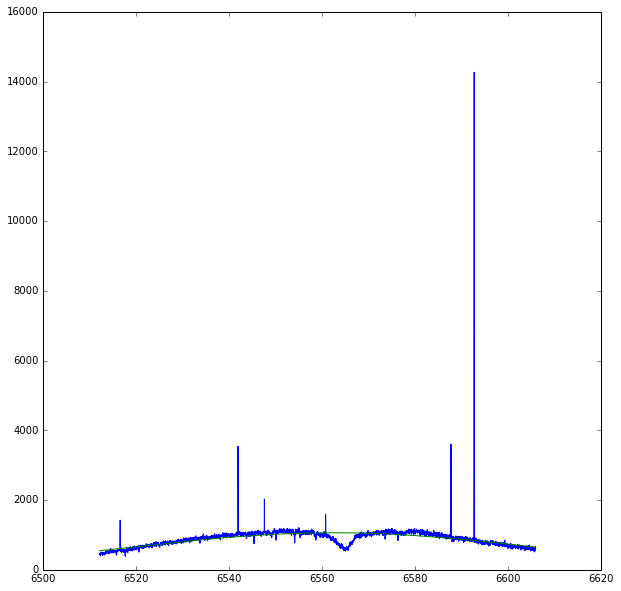

In [44]:
mod = GaussianModel()
pars = mod.guess(y,x=x)
out = mod.fit(y, pars, x=x)
plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.plot(x, out.best_fit)
print(out.fit_report())
print('Center at ' + str(out.best_values['center']) + ' Angstroms for our created reduced image.')

We see that we got a center wavelength of a little under 6563 Angstroms. That was the holy wavelength we were searhing for! 6563 Angstroms is famous for being the rest wavelength of the H-alpha absorption line. That red line above the dip is our Gaussian curve that was fitted to the data. 

Let's compare the center value from our created reduced image with the center value from the reduced image that we were provided. All we have to do is change our y value data and repeat the Gaussian fitting process.

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 4000
    # variables        = 3
    chi-square         = 132238103.376
    reduced chi-square = 33084.339
    Akaike info crit   = 41633.261
    Bayesian info crit = 41652.143
[[Variables]]
    sigma:       46.7969773 +/- 0.557629 (1.19%) (init= 31.59765)
    center:      6563.31318 +/- 0.295791 (0.00%) (init= 6556.135)
    amplitude:   1.2394e+05 +/- 1.17e+03 (0.94%) (init= 406567.4)
    fwhm:        110.198458 +/- 1.313116 (1.19%)  == '2.3548200*sigma'
    height:      1056.62409 +/- 4.617651 (0.44%)  == '0.3989423*amplitude/sigma'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, amplitude)          =  0.943 

Center at 6563.31318389 Angstroms for the reduced image we were provided.


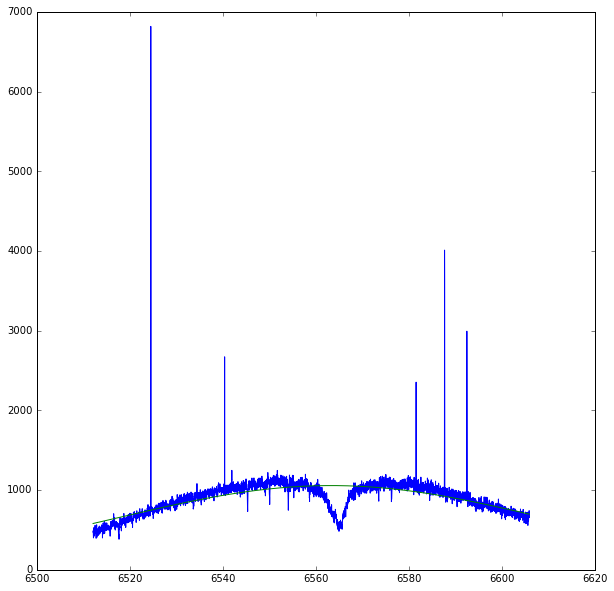

In [45]:
x = wave_values[53,0:4000]
y = reduced_image_fits[53,0:4000]

mod = GaussianModel()
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.plot(x, out.best_fit)
print(out.fit_report(min_correl = 0.25))
print('Center at ' + str(out.best_values['center']) + ' Angstroms for the reduced image we were provided.')

We get a center value here of a little more than 6563 Angstroms. The two center values are within one Angstrom of each other, so I think we can call that a win. Plus they are both close enough to 6563 Angstroms that they are easily recognized as H-alpha absorption. Safe to say our Gaussian fitting was a success, good job.

## Creating an algorithm to identify cosmic rays

For our last task let's tackle cosmic rays. "Cosmic rays are immensely high-energy radiation, mainly originating outside the Solar System. They may produce showers of secondary particles that penetrate and impact the Earth's atmosphere and sometimes even reach the surface." They are composed primarily of high-energy protons and atomic nuclei, and their origin is still a mystery. They show up on our 2D arrays as white specs, and on our 1D arrays as very tall and steep spikes. In this tutorial we want to be able to come up with a way of identifying cosmic rays on our one-dimensional plots and marking their positions. Once we have decided how we want to identify them, we can create a function in Python that was search through our plots and mark anything that appears to be a cosmic ray.

I think the best method to identify a cosmic ray is by the height and narrowness of its spike on a one-dimensional plot. I am going to set the conditions that a cosmic ray on a one-dimensional plot must:
- Have a peak value higher than the bias value multiplied by 1.25
- Have a spike width of seven pixels or less
To find these cosmic ray spikes we will have to write code that will iterate through the pixel values and find those pixels which pass the two conditions listed above. 

In order to mark the positions of these cosmic ray peaks, let's use a full-width-half-max (FWHM) method. This method calculates the full width of the peak where the intensity measurement is half of the peak value. The FWHM method gives us a good marking of at which pixel the cosmic ray is located, even if the max value is not at the center of the peak width. 

Let's define a function `cosmic_ray_spot()` that will iterate through each pixel value of a one-dimensional spectrum. As it iterates, the function will look for pixels which satisfy our two conditions above. At any pixels that satisfy the conditions, the function will use FWHM method to mark the peaks. The function will mark these peaks with a vertical red line, using the `plt.axvline()` function. All our `cosmic_ray_spot()` function will need as an input will be a one-dimensional spectrum.


In [46]:
def cosmic_ray_spot(patch_1D):
    plt.figure(figsize=(10,10))
    plt.plot(patch_1D, color = 'b')
    for i in range(5, patch_1D.size - 5):
        if ((patch_1D[i]>patch_1D[i-1]) and (patch_1D[i]>patch_1D[i+1]) and (patch_1D[i]>(bias*1.25))
            and (patch_1D[i-3]<=(bias*1.25)) and (patch_1D[i+3]<=(bias*1.25))):
            half_max = ((patch_1D[i]) + (patch_1D[i+5] + patch_1D[i-5])/2)/2
            left_side = np.where(patch_1D[:i] <= half_max)
            left_mark = left_side[0][-1]
            right_side = np.where(patch_1D[i:] <= half_max)
            right_mark = right_side[0][0] + i
            peak_x = right_mark - ((right_mark - left_mark)/2)
            plt.axvline(x=peak_x, ymin = np.min(patch_1D) - 1000, color = 'r', linestyle = '-.')

This may look like some complicated code, but looking up [FWHM](https://en.wikipedia.org/wiki/Full_width_at_half_maximum), and maybe the functions [plt.axvline()](http://matplotlib.org/api/pyplot_api.html) and [np.where()](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.where.html) will help a lot with understanding what the code is actually doing.

Let's try out our function on the H-alpha absorption feature in our reduced image. Remember that the feature is located in the 53rd order of the image, so we can just use `poly_reduced_image[53]` as our one-dimensional spectrum.

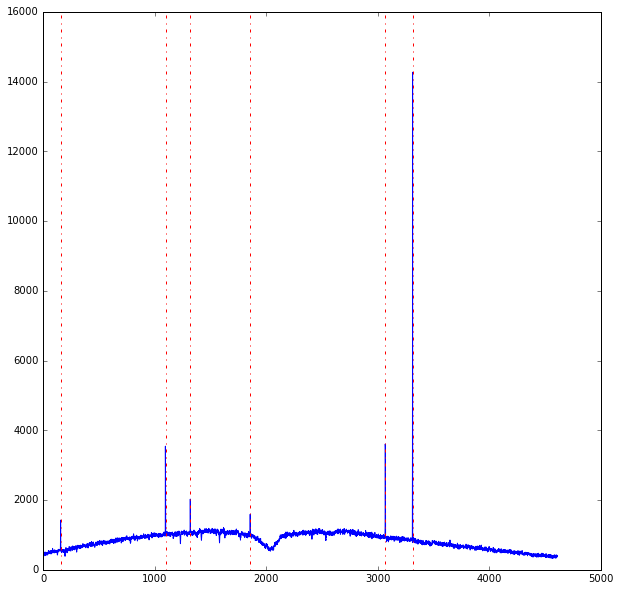

In [47]:
cosmic_ray_spot(poly_reduced_image[53])

Would you look at that, it worked! All of those spikes marked with the vertical red lines are likely cosmic rays based off of their height and narrowness. Let's try our function out on the spectrum that has the Sodium-D absorption features. I'm not sure where the Na-D features are in the reduced image, so we can use the `Na_D_patch_1D` that we created earlier in this tutorial.

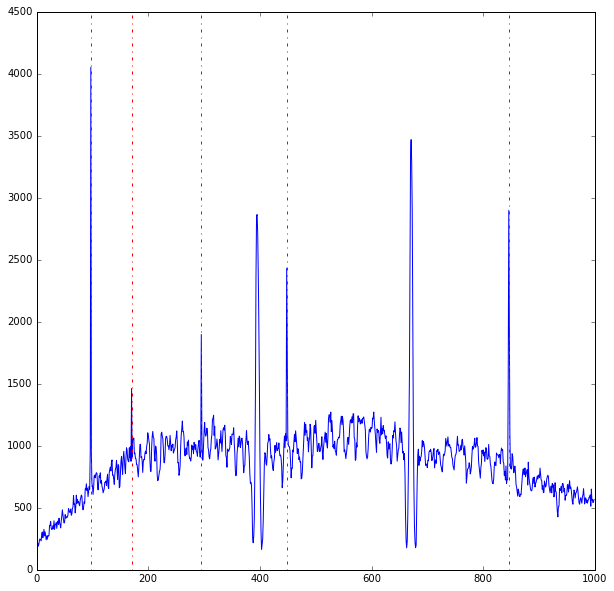

In [48]:
cosmic_ray_spot(Na_D_patch_1D)

Hey, it works! And notice how it didn't mark the peaks that we discussed were caused by sodium streetlights. Those streetlight emission features were not marked because the width of their peaks was too big, which made them distinguishable from the likely cosmic rays in the spectrum. 

## What more can you do?
Well, that's the end of this tutorial. Now I hope you can come up with some more ideas of how to visualize and analyze the data, and possibly some other cosmic ray detection methods which may be more reliable. Try to have fun with it, and thank you so much for helping us out at Breakthrough Listen by looking through some of this data. With these skills learne and practiced, there's a chance that you could be the one to find signs of Extraterrestrial Intelligence!!! The more eyes the better. Best of luck to you!